In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import numpy as np
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [3]:
import torch
from torch import nn
import pandas as pd
from torch.autograd import Variable
from Models import GateCNNFahsionSoftmax, CNNFashion, GateCNNFashion
from Util import FedAvg, Preparedata, Sample_node
from torch.utils.data import DataLoader, Dataset
from Update import ClientUpdate

In [4]:
import torch
from torch import nn, autograd

In [5]:
trans_fashionmnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset_train = datasets.FashionMNIST('../data/fashion-mnist', train=True, download = True, transform = trans_fashionmnist)
dataset_test = datasets.FashionMNIST('../data/fashion-mnist',train=False, download = True, transform = trans_fashionmnist)

In [6]:
num_clients = 4
ntrain = 1000
ntest = 300
train_sets = []
test_sets = []
percent = 0.9
#creat no-iid data
# for i in range(num_clients):
#     train_set, test_set = Preparedata(dataset_train, dataset_test, ntrain, ntest, class_number = [i%10], percent = percent)
#     train_sets.append(train_set)
#     test_sets.append(test_set)

In [58]:
# train_set, test_set = Preparedata(shuffle(dataset_train), dataset_test, ntrain, ntest, class_number = [0,1,2], percent = percent)
# train_sets.append(train_set)
# test_sets.append(test_set)


# train_set, test_set = Preparedata(dataset_train, dataset_test, ntrain, ntest, class_number = [0,1,3], percent = percent)
# train_sets.append(train_set)
# test_sets.append(test_set)


# train_set, test_set = Preparedata(shuffle(dataset_train), dataset_test, ntrain, ntest, class_number = [1,2,4], percent = percent)
# train_sets.append(train_set)
# test_sets.append(test_set)


# train_set, test_set = Preparedata(dataset_train, dataset_test, ntrain, ntest, class_number = [0,1,3], percent = percent)
# train_sets.append(train_set)
# test_sets.append(test_set)


# train_set, test_set = Preparedata(dataset_train, dataset_test, ntrain, ntest, class_number = [0,2,3], percent = percent)
# train_sets.append(train_set)
# test_sets.append(test_set)

In [59]:
# train_set, test_set = Preparedata(dataset_train, dataset_test, ntrain, ntest, class_number = [5,6,8], percent = percent)
# train_sets.append(train_set)
# test_sets.append(test_set)


# train_set, test_set = Preparedata(shuffle(dataset_train), dataset_test, ntrain, ntest, class_number = [6,8,9], percent = percent)
# train_sets.append(train_set)
# test_sets.append(test_set)


# train_set, test_set = Preparedata(dataset_train, dataset_test, ntrain, ntest, class_number = [7,8,9], percent = percent)
# train_sets.append(train_set)
# test_sets.append(test_set)


# train_set, test_set = Preparedata(shuffle(dataset_train), dataset_test, ntrain, ntest, class_number = [5,6,8], percent = percent)
# train_sets.append(train_set)
# test_sets.append(test_set)


# train_set, test_set = Preparedata(dataset_train, dataset_test, ntrain, ntest, class_number = [5,6,7], percent = percent)
# train_sets.append(train_set)
# test_sets.append(test_set)

In [7]:
class ClientUpdate(object):
    def __init__(self, train_set=None,  test_set=None, idx=None):
        
        self.loss_func = nn.NLLLoss()
        
        self.train_set, self.val_set = torch.utils.data.random_split(train_set, [800, 200], torch.Generator().manual_seed(idx))

        self.ldr_train = DataLoader(self.train_set, batch_size=10, shuffle=True)
        self.ldr_val = DataLoader(self.val_set, batch_size = 1, shuffle=True)

        self.test_set = test_set
        self.ldr_test = DataLoader(self.test_set, batch_size = 1, shuffle=True)
    
    def train(self, net, n_epochs,learning_rate):
        
        net.train()
        
        optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)

        epoch_loss = []

        for iter in range(n_epochs):
            net.train()
            batch_loss = []
            
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = (images, labels)
                net.zero_grad()
                log_probs = net(images.float())
    
                loss = self.loss_func(log_probs, labels)
                loss.backward()
                optimizer.step()
                
                batch_loss.append(loss.item())
                
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
            
#             val_acc, val_loss = self.validate(net,True)
#             print(val_acc)

        return net.state_dict(), epoch_loss[-1]
   
    
    def train_finetune(self, net, n_epochs, learning_rate):
        net.train()
        
        optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
        
        patience = 10
        epoch_loss = []
        epoch_train_accuracy = []
        model_best = net.state_dict()
        train_acc_best = np.inf
        val_acc_best = -np.inf
        val_loss_best = np.inf
        counter = 0
        
        for iter in range(n_epochs):
            net.train()
            batch_loss = []
            correct = 0
            
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = (images, labels)
                net.zero_grad()
                log_probs = net(images.float())
                loss = self.loss_func(log_probs, labels)
                loss.backward()
                optimizer.step()
                batch_loss.append(loss.item())
                _, predicted = torch.max(log_probs.data, 1)
                correct += (predicted == labels).sum().item()
            train_accuracy = 100.00 * correct / len(self.ldr_train.dataset)
            epoch_train_accuracy.append(train_accuracy)
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
            
            if(iter%5==0):
                val_acc, val_loss = self.validate(net,True)
                net.train()
                if(val_loss < val_loss_best - 0.01):
                    counter = 0
                    model_best = net.state_dict()
                    val_acc_best = val_acc
                    val_loss_best = val_loss
                    train_acc_best = train_accuracy
                    print("Iter: %d | %.2f" %(iter,val_acc_best))
                else:
                    counter = counter+1
                    
                # early stop
                if counter == patience:
                    return model_best, epoch_loss[-1], val_acc_best, train_acc_best
                    
    
        return model_best, epoch_loss[-1], val_acc_best, train_acc_best
     
        
    def train_mix(self, net_local, net_trans, gate, train_gate_only, n_epochs, early_stop, learning_rate, val):

        print("start train mix model")        
        gate.train()
        net_local.train()
        net_trans.train()

        if(train_gate_only):
            optimizer = torch.optim.Adam(gate.parameters(),lr=learning_rate)
        else:
            optimizer = torch.optim.Adam(list(gate.parameters())+list(net_local.parameters()),lr=learning_rate)

      
        patience = 30
        epoch_loss = []
        gate_best = gate.state_dict()
        local_best = net_local.state_dict()
        trans_best = net_trans.state_dict()
        val_acc_best = -np.inf
        val_loss_best = np.inf
        counter = 0
        gate_values_best = 0

        
        for iter in range(n_epochs):
            net_local.train()
            net_trans.train()
            gate.train()

            batch_loss = []

            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = (images, labels)

                net_local.zero_grad()
                net_trans.zero_grad()
                gate.zero_grad()

                gate_weight = gate(images.float())
            

                # gate_weight*wi + gate_weight*fintuned
                local_prob = gate_weight*net_local(images.float())+(1-gate_weight)*net_trans(images.float())
                loss = self.loss_func(local_prob,labels)
  
                loss.backward()
                optimizer.step()
                batch_loss.append(loss.item())

            epoch_loss.append(sum(batch_loss)/len(batch_loss))
            
            
            if(early_stop):
                if(iter%5==0):
                    val_acc, val_loss = self.validate_mix(net_local, net_trans, gate, val)
                    net_local.train()
                    net_trans.train()
                    gate.train()

                    if(val_loss < val_loss_best - 0.01):
                        counter = 0
                        gate_best = gate.state_dict()
                        local_best = net_local.state_dict()
                        trans_best = net_trans.state_dict()
                        val_acc_best = val_acc
                        val_loss_best = val_loss
                        gate_weight_best = gate_weight
                        print("Iter: %d | %.2f" %(iter,val_acc_best))
                    else:
                        counter = counter + 1
                        #print(counter)
                
                if counter == patience:
                    return gate_best, local_best, trans_best, epoch_loss[-1],val_acc_best, sum(gate_weight_best) / len(gate_weight_best)


        return gate_best, local_best, trans_best, epoch_loss[-1],val_acc_best, sum(gate_weight_best) / len(gate_weight_best)
    
        
    def train_mix_clients(self, net_local, net_trans, net_clients, gate_frezze, gate, train_gate_only, n_epochs, early_stop, learning_rate, val):

        print("start train mix model")        
        gate.train()
        net_local.train()
        net_trans.train()

        if(train_gate_only):
            optimizer = torch.optim.Adam(gate.parameters(),lr=learning_rate)
        else:
            optimizer = torch.optim.Adam(list(gate.parameters())+list(net_local.parameters()),lr=learning_rate)

      
        patience = 30
        epoch_loss = []
        gate_best = gate.state_dict()
        local_best = net_local.state_dict()
        trans_best = net_trans.state_dict()
        val_acc_best = -np.inf
        val_loss_best = np.inf
        counter = 0
        gate_values_best = 0

        
        for iter in range(n_epochs):
            net_local.train()
            net_trans.train()
            gate.train()

            batch_loss = []

            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = (images, labels)

                net_local.zero_grad()
                net_trans.zero_grad()
                gate.zero_grad()

                gate_inner = gate_frezze(images.float())
                gate_outer = gate(images.float())
             

                # gate_weight*wi + gate_weight*fintuned
                local_prob_inner = gate_inner*net_local(images.float())+(1-gate_inner)*net_trans(images.float())
                local_prob = gate_outer*net_clients(images.float())+(1-gate_outer)*local_prob_inner
                loss = self.loss_func(local_prob,labels)
  
                loss.backward()
                optimizer.step()
                batch_loss.append(loss.item())

            epoch_loss.append(sum(batch_loss)/len(batch_loss))
            
            
            if(early_stop):
                if(iter%5==0):
                    val_acc, val_loss = self.validate_mix_clients(net_local, net_trans, net_clients, gate_frezze, gate, val)
                    net_local.train()
                    net_trans.train()
                    gate.train()

                    if(val_loss < val_loss_best - 0.01):
                        counter = 0
                        gate_best = gate.state_dict()
                        local_best = net_local.state_dict()
                        trans_best = net_trans.state_dict()
                        val_acc_best = val_acc
                        val_loss_best = val_loss
                        gate_weight_best = weight
                        print("Iter: %d | %.2f" %(iter,val_acc_best))
                    else:
                        counter = counter + 1
                        #print(counter)
                
                if counter == patience:
                    return gate_best, local_best, trans_best, epoch_loss[-1],val_acc_best, gate_weight_best


        return gate_best, local_best, trans_best, epoch_loss[-1],val_acc_best, gate_outer
    
    
    def validate(self,net,val):
        # if true validate dataset, if false use test detaset
        if(val):
            dataloader = self.ldr_val
        else:
            dataloader = self.ldr_test
       
        with torch.no_grad():
            net.eval()
            # validate
            val_loss = 0
            correct = 0
            for idx, (data, target) in enumerate(dataloader):
                data, target = (data, target)
                log_probs = net(data.float())

                val_loss += self.loss_func(log_probs, target).item()

                y_pred = log_probs.data.max(1, keepdim=True)[1]
                correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

            val_loss /= len(dataloader.dataset)
            accuracy = 100.00 * correct / len(dataloader.dataset)
   
        return accuracy.item(), val_loss
    
    def validate_mix(self, net_l, net_t, gate, val):
        # if true validate dataset, if false use test detaset
        if(val):
            dataloader = self.ldr_val
        else:
            dataloader = self.ldr_test
        
        with torch.no_grad():
            net_l.eval()
            net_t.eval()
            gate.eval()
            val_loss = 0
            correct = 0
            gate_values = np.array([])
            label_values = np.array([])
            
            for idx, (data,target) in enumerate(dataloader):
                data, target = (data,target)
                gate_weight = gate(data.float())
                
                log_prob = gate_weight*net_l(data.float())+(1-gate_weight)*net_t(data.float())
                

                val_loss += self.loss_func(log_prob,target).item()
                y_pred = log_prob.data.max(1,keepdim=True)[1]
                correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

        val_loss /= len(dataloader.dataset)
        accuracy = 100.00 * correct / len(dataloader.dataset)
        return accuracy.item(), val_loss
    
    
    
    def validate_mix_clients(self, net_l, net_t, net_c, gate_f, gate, val):
        # if true validate dataset, if false use test detaset
        if(val):
            dataloader = self.ldr_val
        else:
            dataloader = self.ldr_test
        
        with torch.no_grad():
            net_l.eval()
            net_t.eval()
            gate.eval()
            net_c.eval()
            val_loss = 0
            correct = 0
            gate_values = np.array([])
            label_values = np.array([])
            
            for idx, (data,target) in enumerate(dataloader):
                data, target = (data,target)
                gate_inner = gate_f(data.float())
                gate_outer = gate(data.float())
                
                local_prob_inner = gate_inner*net_l(data.float())+(1-gate_inner)*net_t(data.float())
                log_prob = gate_outer*net_c(data.float())+(1-gate_outer)*local_prob_inner

                val_loss += self.loss_func(log_prob,target).item()
                y_pred = log_prob.data.max(1,keepdim=True)[1]
                correct += y_pred.eq(target.data.view_as(y_pred)).long().cpu().sum()

        val_loss /= len(dataloader.dataset)
        accuracy = 100.00 * correct / len(dataloader.dataset)
        return accuracy.item(), val_loss


In [8]:
num_classes = 10

In [9]:
# initailize the probability_distribution
probability_grapd = []
for i in range (num_clients):
    probability_grapd.append([1/(num_clients-1)]*(num_clients-1))

In [10]:
# initailize the modle of every client
net_glob_fedAvg = CNNFashion(num_classes)
net_locals = [] # save the local model of every client

for idx in range(num_clients):
    net_local = CNNFashion(num_classes)
    net_locals.append(net_local)

In [11]:
# initialize all the gate_modle
gate_models = []

for idx in range(num_clients):
    gate_model = GateCNNFashion()
    gate_models.append(gate_model)

In [12]:
# initialize allclient
# clients = []

# for idx in range(num_clients):

#     client = ClientUpdate(train_set=train_sets[idx], test_set = test_sets[idx],
#                                idx = idx)
#     clients.append(client)

In [13]:
local_ep = 200
lr = 1e-4

w_fedAvg = []
alpha = []
train_loss = []
val_loss = []
val_acc = []
w_clients = []
net_fed = []
val_local = []
fintuned_acc = []

In [ ]:

# update every client weight
for ite in range(15):
    train_sets = []
    
    train_set, test_set = Preparedata(shuffle(dataset_train), dataset_test, ntrain, ntest, class_number = [0,1,2], percent = percent)
    train_sets.append(train_set)
    test_sets.append(test_set)

    train_set, test_set = Preparedata(shuffle(dataset_train), dataset_test, ntrain, ntest, class_number = [4,1,2], percent = percent)
    train_sets.append(train_set)
    test_sets.append(test_set)
    
    train_set, test_set = Preparedata(shuffle(dataset_train), dataset_test, ntrain, ntest, class_number = [6,8,9], percent = percent)
    train_sets.append(train_set)
    test_sets.append(test_set)
    
    train_set, test_set = Preparedata(shuffle(dataset_train), dataset_test, ntrain, ntest, class_number = [5,6,8], percent = percent)
    train_sets.append(train_set)
    test_sets.append(test_set)

    
    print("Loop %d" %(ite))
    #val_local = []
    for idx in range(num_clients):
        print("Client %d" %(idx))
        client = ClientUpdate(train_set=train_sets[idx], test_set = test_sets[idx],
                               idx = idx)

        # trian the ith w
        net_updated, train_loss_idx = client.train(net = net_locals[idx], n_epochs = 100,learning_rate = lr)

        w_fedAvg.append(copy.deepcopy(net_updated))

        net_locals[idx].load_state_dict(w_fedAvg[idx])

        train_loss.append(train_loss_idx)

        # envaluate the local nets
        local_val_acc, val_loss = client.validate(net_locals[idx],False)
        print(local_val_acc) 
        val_local.append(local_val_acc)



    w_clients = []
    if (ite == 0):
        for idx  in range (num_clients):
            w_clients.append(net_locals[idx].state_dict())
    else: 
        for idx  in range (num_clients):
            w_clients.append(fintuned_nets[idx].state_dict())


    net_glob = []
    fintuned_nets = []
    selected_clients = []
    #fintuned_acc = []

    for idx in range(num_clients):
        w =[]

        list_of_candidates = list(range(0,num_clients))
        list_of_candidates.remove(idx)

        selected_client = Sample_node(2, idx, list_of_candidates, probability_grapd[idx])
        #selected_client = [0,1,3,4]
        # append selected clients for update the weight 
        selected_clients.append(selected_client)


        for i in selected_client:
             w.append(w_clients[i])

        alpha = [1/len(selected_client)]*len(selected_client)

        w_global = FedAvg(w,alpha)
        net_glob_fedAvg.load_state_dict(w_global)
        net_glob.append(net_glob_fedAvg)


        print("Finetune %d" %(idx))
        # get the fituned w of other clients
        client = ClientUpdate(train_set=train_sets[idx], test_set = test_sets[idx],
                                   idx = idx)
        # model_best, epoch_loss[-1], val_acc_best, train_acc_best
        net_w, train_loss_idx, val_acc_idx, train_acc_idx = client.train_finetune(net = net_glob_fedAvg, 
                                                n_epochs =200, learning_rate = 1e-4)

        ft_net = copy.deepcopy(net_glob_fedAvg)
        ft_net.load_state_dict(net_w)
        fintuned_nets.append(ft_net)
        #net_locals[idx] = ft_net
        net_locals[idx] = fintuned_nets[idx]


        fintuned_val_acc, val_loss = client.validate(ft_net,False)
        fintuned_acc.append(fintuned_val_acc)
        print(fintuned_val_acc)  

    print(selected_clients)
    plt.plot(val_local, 'r', fintuned_acc, 'b')
    
    for idx in range(num_clients):

        if (val_local[idx+ite*num_clients] + 1 <= fintuned_acc[idx+ite*num_clients]):
            # increase weight

            for item in selected_clients[idx]:
                if (item > idx):
                    item = item-1
                probability_grapd[idx][item] = probability_grapd[idx][item]*1.2
        elif(val_local[idx+ite*num_clients] - 1 >= fintuned_acc[idx+ite*num_clients]):
            for item in selected_clients[idx]:
                if (item > idx):
                    item = item-1
                probability_grapd[idx][item] = probability_grapd[idx][item]*0.8

        probability_grapd[idx] = [x / sum(probability_grapd[idx]) for x in probability_grapd[idx]]
    # mix_fin_local_acc = []
    # for idx in range(num_clients):
    #     client = clients[idx]
    #     client = ClientUpdate(train_set=train_sets[idx], test_set = test_sets[idx],
    #                                idx = idx)
    #     gate_w, local_w, trans_w, epoch_loss, accuracy, weight = client.train_mix(net_locals[idx],fintuned_nets[idx],  
    #                                          gate = gate_models[idx], train_gate_only = True, n_epochs =100, 
    #                                          early_stop=True, learning_rate = 5e-4, val = True)

    #     gate_models[idx].load_state_dict(gate_w)
    #     accuracy, val_loss = client.validate_mix(net_locals[idx],fintuned_nets[idx],gate_models[idx], False)
    #     mix_fin_local_acc.append(accuracy)
    #     print(accuracy)

    #     net_locals[idx] = fintuned_nets[idx]



    # plt.plot(val_local, 'r', fintuned_acc, 'b', mix_fin_local_acc, 'y')
    

Loop 0
Client 0
86.0
Client 1
77.66666412353516
Client 2
87.0
Client 3
86.0
Finetune 0
Iter: 0 | 65.00
Iter: 5 | 64.50
Iter: 10 | 87.00
Iter: 15 | 87.00
Iter: 25 | 88.00
85.66666412353516
Finetune 1
Iter: 0 | 2.00
Iter: 5 | 59.50
Iter: 10 | 63.00
Iter: 20 | 66.00
Iter: 25 | 72.00
Iter: 30 | 75.00
Iter: 35 | 74.50
Iter: 40 | 76.50
Iter: 50 | 77.00
Iter: 65 | 77.50
Iter: 90 | 79.00
Iter: 125 | 80.50
Iter: 175 | 80.50
77.66666412353516
Finetune 2
Iter: 0 | 3.00
Iter: 5 | 79.50
Iter: 10 | 87.00
Iter: 15 | 87.50
88.0
Finetune 3
Iter: 0 | 2.50
Iter: 5 | 76.00
Iter: 10 | 82.00
Iter: 15 | 83.00
Iter: 20 | 85.00
Iter: 30 | 86.50
Iter: 75 | 86.50
87.33333587646484
[[2, 1], [2, 3], [3, 0], [0, 1]]
Loop 1
Client 0
86.0
Client 1
77.66666412353516
Client 2
87.0
Client 3
86.0
Finetune 0
Iter: 0 | 57.50
Iter: 5 | 57.50
Iter: 10 | 82.00
Iter: 15 | 82.50
Iter: 25 | 82.50
Iter: 50 | 84.00
86.0
Finetune 1
Iter: 0 | 2.50
Iter: 5 | 54.50
Iter: 10 | 56.00
Iter: 20 | 57.50
60.33333206176758
Finetune 2
Iter: 0

In [ ]:
probability_grapd

In [50]:
for idx in range(num_clients):
   
    if (val_local[idx] < fintuned_acc[idx]):
        # increase weight
  
        for item in selected_clients[idx]:
            if (item > idx):
                item = item-1
            probability_grapd[idx][item] = probability_grapd[idx][item]*1.2
    else:
        for item in selected_clients[idx]:
            if (item > idx):
                item = item-1
            probability_grapd[idx][item] = probability_grapd[idx][item]*0.8

    probability_grapd[idx] = [x / sum(probability_grapd[idx]) for x in probability_grapd[idx]]

In [19]:
print(net_locals)
print(fintuned_nets)
# print(mix_fin_local_acc)

In [16]:
w_clients = []
for idx  in range (num_clients):
    w_clients.append(net_locals[idx].state_dict())

In [17]:
net_glob = []
fintuned_nets = []
selected_clients = []
Fintuned_acc = []

for idx in range(num_clients):
    
    
    w =[]

    list_of_candidates = list(range(0,num_clients))
    list_of_candidates.remove(idx)

    selected_client = Sample_node(2, idx, list_of_candidates, probability_grapd[idx])
    #selected_client = [0,1,3,4]
    # append selected clients for update the weight 
    selected_clients.append(selected_client)
   

    for i in selected_client:
         w.append(w_clients[i])

    alpha = [1/len(selected_client)]*len(selected_client)

    w_global = FedAvg(w,alpha)
    net_glob_fedAvg.load_state_dict(w_global)
    net_glob.append(net_glob_fedAvg)


    print("Finetune %d" %(idx))
    # get the fituned w of other clients
    client = ClientUpdate(train_set=train_sets[idx], test_set = test_sets[idx],
                               idx = idx)
    # model_best, epoch_loss[-1], val_acc_best, train_acc_best
    net_w, train_loss_idx, val_acc_idx, train_acc_idx = client.train_finetune(net = net_glob_fedAvg, 
                                            n_epochs =200, learning_rate = 1e-4)

    ft_net = copy.deepcopy(net_glob_fedAvg)
    ft_net.load_state_dict(net_w)
    fintuned_nets.append(ft_net)


    val_acc, val_loss = client.validate(ft_net,False)
    Fintuned_acc.append(val_acc)
    print(val_acc)  
    


Finetune 0
Iter: 0 | 65.00
Iter: 5 | 65.00
Iter: 10 | 67.00
Iter: 15 | 69.50
Iter: 25 | 68.00
Iter: 40 | 70.00
74.0
Finetune 1
Iter: 0 | 74.50
Iter: 5 | 75.50
Iter: 10 | 75.50
Iter: 15 | 74.00
Iter: 20 | 74.50
Iter: 35 | 75.00
Iter: 50 | 76.50
Iter: 75 | 77.00
Iter: 95 | 79.00
77.33333587646484
Finetune 2
Iter: 0 | 66.00
Iter: 5 | 66.50
Iter: 10 | 67.50
Iter: 15 | 68.50
Iter: 25 | 70.00
Iter: 35 | 73.00
Iter: 60 | 74.50
Iter: 80 | 75.00
Iter: 90 | 76.00
Iter: 125 | 77.50
77.0
Finetune 3
Iter: 0 | 70.50
Iter: 5 | 69.50
Iter: 10 | 76.50
Iter: 15 | 77.50
Iter: 20 | 76.50
Iter: 30 | 79.50
Iter: 45 | 79.50
Iter: 75 | 80.00
79.33333587646484
Finetune 4
Iter: 0 | 66.00
Iter: 5 | 65.50
Iter: 10 | 68.50
Iter: 15 | 70.00
Iter: 30 | 70.00
Iter: 60 | 70.50
79.66666412353516
Finetune 5
Iter: 0 | 64.00
Iter: 5 | 68.50
Iter: 10 | 73.50
Iter: 15 | 73.50
Iter: 25 | 75.00
Iter: 35 | 73.50
Iter: 60 | 76.00
75.33333587646484
Finetune 6
Iter: 0 | 56.50
Iter: 5 | 57.00
Iter: 10 | 57.50
Iter: 15 | 57.50
Iter

In [21]:
print(selected_clients)

[[2, 4], [2, 4], [4, 0], [0, 4], [0, 2]]


In [19]:
# net_glob = []
# fintuned_nets = []
# # the fedavg of every client
# for idx in range(num_clients):
#     w =[]
    
#     for i in range(num_clients):
#         if i != idx:
#             w.append(w_clients[i])
            
#     alpha = [1/(num_clients-1)]*(num_clients-1)
     
#     w_global = FedAvg(w,alpha)
#     net_glob_fedAvg.load_state_dict(w_global)
#     net_glob.append(net_glob_fedAvg)
    
#     print("Finetune %d" %(idx))
#     # get the fituned w of other clients
#     client = ClientUpdate(train_set=train_sets[idx], test_set = test_sets[idx],
#                                idx = idx)
#     # model_best, epoch_loss[-1], val_acc_best, train_acc_best
#     net_w, train_loss_idx, val_acc_idx, train_acc_idx = client.train_finetune(net = net_glob_fedAvg, 
#                                             n_epochs =150, learning_rate = 1e-4)

#     ft_net = copy.deepcopy(net_glob_fedAvg)
#     ft_net.load_state_dict(net_w)
#     fintuned_nets.append(ft_net)

#     val_acc, val_loss = client.validate(ft_net,False)
#     print(val_acc)  
 

In [20]:
# initialize all the gate_modle
gate_models = []
for idx in range(num_clients):
    gate_model = GateCNNFashion()
    gate_models.append(gate_model)

In [22]:
mix_fin_local_acc = []
for idx in range(num_clients):
    client = clients[idx]
    client = ClientUpdate(train_set=train_sets[idx], test_set = test_sets[idx],
                               idx = idx)
    gate_w, local_w, trans_w, epoch_loss, accuracy, weight = client.train_mix(net_locals[idx],fintuned_nets[idx],  
                                         gate = gate_models[idx], train_gate_only = True, n_epochs =200, 
                                         early_stop=True, learning_rate = 5e-4, val = True)
    
    gate_models[idx].load_state_dict(gate_w)
    accuracy, val_loss = client.validate_mix(net_locals[idx],fintuned_nets[idx],gate_models[idx], False)
    mix_fin_local_acc.append(accuracy)
    print(accuracy)
    
    


start train mix model
Iter: 0 | 67.50
73.33333587646484
start train mix model
Iter: 0 | 64.00
Iter: 5 | 79.50
82.0
start train mix model
Iter: 0 | 75.00
Iter: 5 | 77.00
Iter: 45 | 77.50
78.66666412353516
start train mix model
Iter: 0 | 80.50
78.0
start train mix model
Iter: 0 | 67.50
70.0


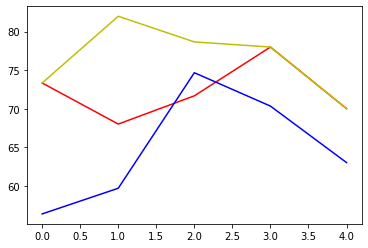

In [24]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(val_local, 'r', fintuned_acc, 'b', Mix_fin_local_acc, 'y')

In [23]:
# gate_models_ll = []

# for idx in range(num_clients):
#     gate_model = GateCNNFashion()
#     gate_models_ll.append(gate_model)

In [ ]:
gate_graph = []

for idx in range(num_clients):    
    gate = []
    loss = []
    acc = []
    #client = clients[idx]
    for i in selected_clients[idx]:
        print("train node %d  with node %d "%(idx,i))
        client = ClientUpdate(train_set=train_sets[idx], test_set = test_sets[idx],
                               idx = idx)
        gate_w, local_w, trans_w, epoch_loss, accuracy, weight = client.train_mix_clients(net_locals[idx],fintuned_nets[idx], net_locals[i], gate_models[idx],
                                                                                  gate = GateCNNFashion(), train_gate_only = True, n_epochs =100, 
                                                                                  early_stop=True, learning_rate = 5e-4, val = False)

        
        gate.append(float(sum(weight)/len(weight)))
    
    gate_graph.append(gate)       

train node 0  with node 8 
start train mix model
Iter: 0 | 74.33
Iter: 25 | 76.33
train node 0  with node 5 
start train mix model
Iter: 0 | 73.67


In [ ]:
gate_graph

In [ ]:
idx = 4
client = ClientUpdate(train_set=train_sets[idx], test_set = test_sets[idx],
                               idx = idx)
net_w, train_loss_idx, val_acc_idx, train_acc_idx = client.train_finetune(net = net_locals[2], 
                                            n_epochs =200, learning_rate = 1e-3)
print(train_acc_idx)

In [ ]:
idx = 4
client = ClientUpdate(train_set=train_sets[idx], test_set = test_sets[idx],
                               idx = idx)
net_w, train_loss_idx, val_acc_idx, train_acc_idx = client.train_finetune(net = net_locals[0], 
                                            n_epochs =200, learning_rate = 1e-3)
print(train_acc_idx)

In [ ]:
idx = 2
client = ClientUpdate(train_set=train_sets[idx], test_set = test_sets[idx],
                               idx = idx)
net_w, train_loss_idx, val_acc_idx, train_acc_idx = client.train_finetune(net = net_locals[2], 
                                            n_epochs =200, learning_rate = 1e-4)
print(train_acc_idx)